# Exploratory Data Analysis for the following cities
- Chicago, IL
- Los Angeles, CA
- Buffalo, NY
- Raleigh, NC


https://docs.safegraph.com/docs/weekly-patterns

In [1]:
import doutils
doutils.nb.megaimport(globals())
%load_ext autoreload
%autoreload 2

from cartoframes import to_carto
from cartoframes.viz import Layer, animation_style, time_series_widget
from cartoframes import delete_table

In [6]:
patterns = "carto-do.safegraph.humanmobility_patterns_usa_latlon_v3_daily_v3"
geography = "carto-do.safegraph.geography_usa_latlon_v3"

bq_client = get_bq_client()

In [7]:
from shapely.geometry import box, Polygon
import h3
from cartoframes.viz import Map, Layer, size_bins_style, color_bins_style, color_continuous_style, basic_style

from sf_utils import *

In [8]:
for k,v in bboxes.items():
    print(k, box(*v).area)

chicago 0.15773980000000037
los_angeles 0.3547760000000067
buffalo 0.09005879347200096
raleigh 0.02192661899999826


### POIS categories analysis

In [5]:
pois_table_id = "carto-do.safegraph.pointsofinterest_coreplaces_usa_latlon_v3_daily_v2"

In [1649]:
poi_query = f"""
SELECT top_category, count(top_category) as n , sum(raw_visit_counts) as sum_visits
FROM `cartodb-on-gcp-datascience.juanluis.safegraph_blackfriday_chicago`
WHERE raw_visit_counts is not null
GROUP BY top_category ORDER BY sum_visits DESC
"""

In [1650]:
top_categories = bq_client.query(poi_query).result().to_dataframe()
top_categories["pctg"] = top_categories.n / top_categories.n.sum() * 100
top_categories["pctg_cum_sum"] = top_categories.pctg.cumsum()

In [1653]:
top_categories.sum_visits = top_categories.sum_visits.astype(np.int64)

In [1654]:
h = top_categories.head(30)

In [1655]:
h.style.background_gradient()

,top_category,n,sum_visits,pctg,pctg_cum_sum
0,Restaurants and Other Eating Places,39580256,9085263904,19.761603,19.761603
1,"Museums, Historical Sites, and Similar Institutions",7146848,6302176832,3.568273,23.329877
2,Lessors of Real Estate,1816288,4380427120,0.906835,24.236712
3,Other Amusement and Recreation Industries,6457736,2035818168,3.224214,27.460926
4,Grocery Stores,6418728,1869822256,3.204738,30.665664
5,Elementary and Secondary Schools,5940184,1804066568,2.965811,33.631475
6,Gasoline Stations,3858944,1311385752,1.926691,35.558166
7,Religious Organizations,16036088,1224489136,8.006487,43.564653
8,Health and Personal Care Stores,5180640,1044493152,2.586586,46.151239
9,"General Merchandise Stores, including Warehouse Clubs and Supercenters",1405472,961833752,0.701723,46.852963


In [1661]:
filtered_categories = top_categories[top_categories.pctg_cum_sum < 90]

In [1662]:
chosen_categories = [
 'Grocery Stores',
 'Clothing Stores',
 'Sporting Goods, Hobby, and Musical Instrument Stores',
 'General Merchandise Stores, including Warehouse Clubs and Supercenters',
 'Department Stores',
 'Electronics and Appliance Stores']

filtered_categories.set_index("top_category").loc[chosen_categories]

,n,sum_visits,pctg,pctg_cum_sum
top_category,,,,
Grocery Stores,6418728,1869822256,3.204738,30.665664
Clothing Stores,4054976,658334040,2.024566,55.793541
"Sporting Goods, Hobby, and Musical Instrument Stores",2917520,757354832,1.456657,53.768976
"General Merchandise Stores, including Warehouse Clubs and Supercenters",1405472,961833752,0.701723,46.852963
Department Stores,539040,600218464,0.269132,56.062673
Electronics and Appliance Stores,1714296,243627144,0.855913,69.371598


In [8]:
cols = ('placekey',
 'latitude',
 'longitude',
 'date_range_start',
 'date_range_end',
 'raw_visit_counts',
 'raw_visitor_counts',
 'visits_by_day',
 'visitor_home_cbgs',
 #'popularity_by_hour',
 #'popularity_by_day',
 'top_category',
 #'sub_category',
 'h3_z7',
 'h3_z8',
 'h3_z9')

In [1666]:
q2 = f"""
SELECT {", ".join(cols)}
FROM `cartodb-on-gcp-datascience.juanluis.safegraph_blackfriday_chicago`
WHERE raw_visit_counts is not null and top_category IN {tuple(chosen_categories)}
"""

In [1667]:
print(q2)


SELECT placekey, latitude, longitude, date_range_start, date_range_end, raw_visit_counts, raw_visitor_counts, visits_by_day, visitor_home_cbgs, top_category, h3_z7, h3_z8, h3_z9
FROM `cartodb-on-gcp-datascience.juanluis.safegraph_blackfriday_chicago`
WHERE raw_visit_counts is not null and top_category IN ('Grocery Stores', 'Clothing Stores', 'Sporting Goods, Hobby, and Musical Instrument Stores', 'General Merchandise Stores, including Warehouse Clubs and Supercenters', 'Department Stores', 'Electronics and Appliance Stores')



In [21]:
bq_table = bq_client.get_table("cartodb-on-gcp-datascience.juanluis.safegraph_blackfriday_chicago")
[t.name for t in bq_table.schema]

In [1670]:
df = bq_client.query(q2).result().to_dataframe()

In [1673]:
raw_visit_counts = df[["date_range_start", "raw_visit_counts", "top_category"]]
daily_visit_counts = df[["date_range_start", "date_range_end", "top_category", "visits_by_day"]]

In [1674]:
bf_2019 = np.datetime64("2019-11-29")
bf_2020 = np.datetime64("2020-11-27")
bf_2021 = np.datetime64("2021-11-26")

In [110]:
import seaborn as sns
import matplotlib.pyplot as plt

### Upscale hotspot areas by zooming out

In [183]:
def generate_map(gettis_ord_df, hotspots, city, upload = False):
    city_name = title_cities.get(city)
    q95_sum = gettis_ord_df.quantile(0.95).values[0]
    if upload:
        to_carto(gettis_ord_df, f"{city}_bf_getis_ord", if_exists = "replace")
        gettis_ord_df = f"{city}_bf_getis_ord"
    continuous_l = Layer(
    gettis_ord_df,
    legends = color_continuous_legend(title = f"Hotspot Areas - {city_name}",
                                      description = "Getis-Ord index over nº of visits",
                                      footer = "Source : Safegraph",
                                      format = ".2f"),
    style = color_continuous_style("gi", range_max=q95_sum, palette = "Geyser"),
    popup_hover= popup_element("gi", title = "Getis-Ord"),
    geom_col="geometry",
    encode_data=False
    )
    hotspot_l = Layer(hotspots, style = basic_style(opacity = 0, stroke_width= 3, stroke_color = "#6E260E"))
    return Map([continuous_l, hotspot_l])
    

In [163]:
chicago_map.publish("chicago_bf_hotspots_map", None, if_exists = "replace")

{'id': 'c9b0056b-372a-4351-8b00-053ee8652686',
 'url': 'https://public.carto.com/kuviz/c9b0056b-372a-4351-8b00-053ee8652686',
 'name': 'chicago_bf_hostpots_map',
 'privacy': 'public'}

### Compute all cities

In [263]:
#maps = {}
title_cities = {'chicago' : 'Chicago', 'los_angeles' : 'Los Angeles', 'buffalo' : "Buffalo", 'raleigh' : "Raleigh"}

In [181]:
#Chicago
city = "chicago"
chicago_gettis_ord_df = get_gettis_ord_df(city, h3_col)
chicago_hotspots_gdf = find_hotspot_geometries(chicago_gettis_ord_df, min_base_cells_in_grandparent = None)
maps[city] = generate_map(chicago_gettis_ord_df, chicago_hotspots_gdf, city, upload = True)

grandparent
872664c13ffffff    49
872664c1affffff    48
872664cadffffff    47
872664ca9ffffff    47
872664c16ffffff    44
872664c1effffff    42
872664ca1ffffff    41
872664c10ffffff    37
Name: gi, dtype: int64
min_base_cells 8.0
Success! Data uploaded to table "chicago_bf_getis_ord" correctly


In [182]:
# Buffalo
city = "buffalo"
buffalo_gettis_ord_df = get_gettis_ord_df(city, h3_col)
buffalo_hotspots_gdf = find_hotspot_geometries(buffalo_gettis_ord_df, min_base_cells_in_grandparent = 6)
maps[city] = generate_map(buffalo_gettis_ord_df, buffalo_hotspots_gdf, city)

grandparent
872aa6c94ffffff    41
872aa6d93ffffff    31
872aa6d81ffffff    23
872aa6c90ffffff    18
872aa6ca0ffffff    16
872b9b36dffffff    15
872aa6d9dffffff    15
872aa6d8affffff     9
Name: gi, dtype: int64
min_base_cells 6


In [165]:
#Los angeles
city = "los_angeles"
los_angeles_gettis_ord_df = get_gettis_ord_df(city, h3_col)
los_angeles_hotspots_gdf = find_hotspot_geometries(los_angeles_gettis_ord_df,
                                                   min_base_cells_in_grandparent = 20,
                                                   top_quantile=0.90,
                                                   verbose=True)
maps[city] = generate_map(los_angeles_gettis_ord_df, los_angeles_hotspots_gdf, city, upload = True)

grandparent
8729a1d62ffffff    49
8729a1d63ffffff    49
8729a1d75ffffff    48
8729a1d6dffffff    47
8729a1d66ffffff    46
8729a0b43ffffff    45
8729a0b49ffffff    44
8729a1d6affffff    42
Name: gi, dtype: int64
min_base_cells 20


In [186]:
#Raleigh
city = "raleigh"
raleigh_gettis_ord_df = get_gettis_ord_df(city, h3_col)
raleigh_hotspots_gdf = find_hotspot_geometries(raleigh_gettis_ord_df, min_base_cells_in_grandparent = 9)
maps[city] = generate_map(raleigh_gettis_ord_df, raleigh_hotspots_gdf, city)

grandparent
872ad69b0ffffff    35
872ad69b2ffffff    16
872a896edffffff    13
872ad69b6ffffff    12
872a896e8ffffff     9
872a896eeffffff     9
872a8965effffff     5
872a89653ffffff     3
Name: gi, dtype: int64
min_base_cells 9


In [188]:
for city, m in maps.items():
    out = m.publish(f"{city}_bf_hotspots_map", None, if_exists="replace")
    print(city, out["url"])

The map has been published. The "cartoframes_b6d1ba1f9dc76077334da2bed59b257e" Maps API key with value "1e9wPMnVPNze9gcEyD2uGw" is being used for the datasets: "los_angeles_bf_getis_ord". You can manage your API keys on your account.
los_angeles https://public.carto.com/kuviz/798b45de-f874-4efd-b04f-fb23fca45dea
The map has been published. The "cartoframes_4e556a7c62dde13100c6cb3a3d9367cc" Maps API key with value "8h00io45jhiaHrTg24B12Q" is being used for the datasets: "chicago_bf_getis_ord". You can manage your API keys on your account.
chicago https://public.carto.com/kuviz/70d7ba34-5707-4355-a5c1-c29e22d82518
buffalo https://public.carto.com/kuviz/c18ee1a3-4572-4e4d-9a3a-6e2cb1a736e9
raleigh https://public.carto.com/kuviz/7976497a-5742-4456-9da9-be55e6201dbb


In [189]:
hotspot_layout =\
Layout([
    maps["chicago"],
    maps["los_angeles"],
    maps["raleigh"],
    maps["buffalo"],
], 2, 2)

In [ ]:
hotspot_layout.publish("safegraph_bf_cities_hotspots", None)

### plot average max value

In [566]:
h3_gdf = df.loc[nov_filter].filter(regex = "raw|h3_z").groupby(h3_col)[["raw_visitor_counts"]].sum()

In [646]:
h3_gdf["geometry"] = list(map(get_h3_pol,h3_gdf.index))
h3_gdf = gpd.GeoDataFrame(h3_gdf, geometry = "geometry")

In [647]:
breaks = h3_gdf.raw_visitor_counts.quantile([0.25,0.5,0.75,0.95]).values

### Calculate Statistics comparing BF 2019  vs 2020

In [192]:
l0 = list(chicago_hotspots_gdf.grandparent.values)
l1 = list(los_angeles_hotspots_gdf.grandparent.values)
l2 = list(buffalo_hotspots_gdf.grandparent.values)
l3 = list(raleigh_hotspots_gdf.grandparent.values)

In [193]:
hotspots_h3_z7 = {
    "chicago": l0,
    "los_angeles" : l1,
    "buffalo" : l2,
    "raleigh" : l3
}

In [194]:
import json
with open("hotspots_h3_z7.json", "w+") as fp:
    json.dump(hotspots_h3_z7, fp) 

In [195]:
hotspot_indices = l0 + l1 + l2 + l3

### Comparing Black fridays

In [298]:
stats_dfs = []
for k,v in bboxes.items():
    stats_q = f"""
    WITH sum_visitors AS (
    SELECT SUM(raw_visitor_counts) as sum_visitors_counts
    FROM `cartodb-on-gcp-datascience.juanluis.safegraph_blackfriday_weekly_patterns_{k}`)
    
    SELECT  EXTRACT(DATE FROM date_range_start) as date,
    SUM(distance_from_home*raw_visitor_counts/sum_visitors_counts) as avg_distance_from_home,
    SUM(raw_visit_counts) as sum_raw_visit_counts,
    SUM(median_dwell*raw_visitor_counts/sum_visitors_counts) as avg_median_dwell,
    FROM `cartodb-on-gcp-datascience.juanluis.safegraph_blackfriday_weekly_patterns_{k}`, sum_visitors
    WHERE raw_visit_counts >= 1 AND h3_z7 IN {tuple(hotspot_indices)}
    GROUP BY date_range_start
    ORDER BY date_range_start
    """
    stats_df = bq_client.query(stats_q).result().to_dataframe()
    stats_df["city"] = k
    stats_dfs.append(stats_df)


In [299]:
city_stats = pd.concat(stats_dfs)
city_stats["black_friday"] = city_stats.date.apply(lambda x: "bf week " + str(x.year))

In [300]:
group = city_stats.groupby("city")["sum_raw_visit_counts"]
city_stats["raw_visit_counts_change"] = group.transform(lambda x: x)/group.transform(max)


In [301]:
import seaborn as sns, matplotlib.pyplot as plt

In [302]:
city_palette = {
    "chicago": "#855C75",
    "los_angeles" : "#D9AF6B",
    "buffalo" : "#AF6458",
    "raleigh" : "#736F4C"
}

In [309]:
variables = {
    "sum_raw_visit_counts" : {"title" : "Total Visitors Measured in Hotpot Areas during Black Friday week",
                              "yscale" : "log",
                              "ylabel" : "Sum of raw visit counts (Log scale)",
                             },
    "avg_distance_from_home" : {"title" : "Average Distance From Home in Hotpot Areas during Black Friday week",
                                "ylabel" : "Average Distance From Home (meters)",
                               },
    "avg_median_dwell" : {"title" : "Average Dwell Time in Hotpot Areas during Black Friday week",
                         "ylabel" : "Average Dwell Time (minutes)"}
}

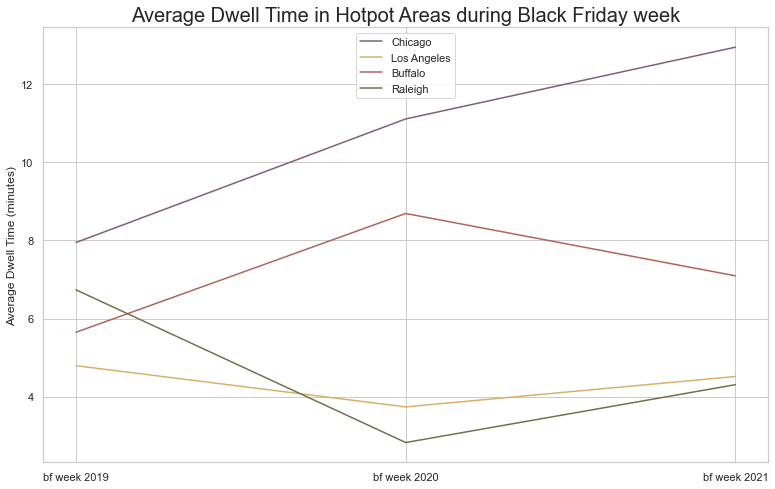

In [323]:
sns.set(style="whitegrid")
compare_variable = "avg_median_dwell" #sum_raw_visit_counts avg_distance_from_home avg_median_dwell, raw_visit_counts_change
fig, ax = plt.subplots(figsize = (13,8))
sns.lineplot(data = city_stats, x = "black_friday", y = compare_variable, hue = "city", palette = city_palette, ax = ax)
v = variables.get(compare_variable)
ax.legend(loc='upper center', labels = title_cities.values())
ax.set(**v, xlabel = None)
ax.set_title(v["title"], size = 20)

if compare_variable in ["sum_raw_visit_counts"]:
    for i, year in enumerate(city_stats.black_friday.unique()):
        y_ticks = city_stats[city_stats.black_friday == year][compare_variable].round(-3)
        for y in y_ticks:
            ax.annotate(str(y)[:-3] + "k", (i,y*1.05), xycoords = "data")
fig.savefig(f"{compare_variable}.png", dpi = 300)